<a href="https://colab.research.google.com/github/BrockDSL/ARCH_Data_Explore/blob/main/Twitter_Data_Explore_and_Export.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![dsl_logo.png](https://raw.githubusercontent.com/BrockDSL/Analyzing_Web_Archives/main/dsl_logo.png)

## Covid-19 Twitter Archive
This notebook explores Twitter data that has been archived in the form of a CSV file. This notebook can be run on Google Collab, mybinder.org, or anywhere the [Jupyter Notebook](https://jupyter.org/) software is installed (including your own computer). 

## How this notebook works

This webpage is a Google Colab notebook and is comprised of different *cells*. Some are code cells that run Python snippets. To works through these cells simply click on the triangle _run_ button in each cell. In order for functionality to be preserved, cells should be executed top to bottom, in the order that they appear. Cells may be executed independently or out of order, in the appropriate context. 

## Load libraries

In [1]:
!pip install pandas matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gdown
from google.colab import files
print("----------------")
print("Libraries Loaded")

----------------
Libraries Loaded


### And Data...

In [2]:
gdown.download("https://github.com/BrockDSL/ARCH_Data_Explore/raw/main/covid_niagara_twitter.csv", quiet=False)
archive_data = pd.read_csv("covid_niagara_twitter.csv")
print()
print("Data Loaded")

Downloading...
From: https://github.com/BrockDSL/ARCH_Data_Explore/raw/main/covid_niagara_twitter.csv
To: /content/covid_niagara_twitter.csv
5.64MB [00:00, 51.9MB/s]



Data Loaded


### Show a single sample of the data

In [3]:
archive_data.sample(1)

,crawl_date,url,handle,text,v_pos,v_neg,v_neu,v_comp
4586,2020-10-03,https://twitter.com/BrockUESRC/status/13120909...,@BrockUESRC,The NPC Speaker Series will take place every W...,0.0,0.0,1.0,0.0


### Total tweets and unique handles

In [4]:
print("Total Number of total tweets in dataset: ",len(archive_data))
print("Total Number of unique handles in dataset: ", len(archive_data.groupby('handle')))


Total Number of total tweets in dataset:  17111
Total Number of unique handles in dataset:  670


### Clean up data by removing captures of the same tweet (duplicates)

In [5]:
#Remove duplicate tweets
archive_data = archive_data.drop_duplicates(subset=['handle','text'],keep='last')
print("Total Number of total unique tweets in dataset: ",len(archive_data))

Total Number of total unique tweets in dataset:  10529


### Some stats on Twitter handles captured in the dataset:

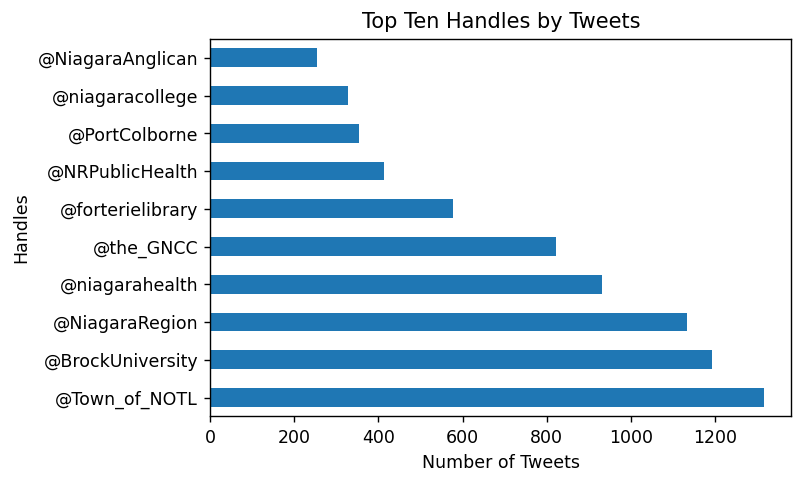

In [20]:
plt.rcParams['figure.dpi'] = 125
ax = archive_data.groupby("handle")["url"].count().sort_values(ascending=False)[:10].plot(kind='barh')
ax.set_title("Top Ten Handles by Tweets")
ax.set_ylabel("Handles")
ax.set_xlabel("Number of Tweets")
plt.show()

In [7]:
res = archive_data.groupby("handle")["url"].count()
u10 = res[res<10]
u100 = res[(res>=10) & (res<100)]
u250 = res[(res>=100) & (res<250)]
oe250 = res[res>=250]

counts = u10.count(), u100.count(), u250.count(), oe250.count()
labels = ["t<10","10<=t<100","100<=t<250", "t>=250"]
cstat="t<10: {}\n\
10<=t<100: {}\n\
100<=t<250: {}\n\
t>=250: {}".format(*counts)

## Number of Handles where t=tweets

In [8]:
print(cstat)

t<10: 604
10<=t<100: 51
100<=t<250: 5
t>=250: 10


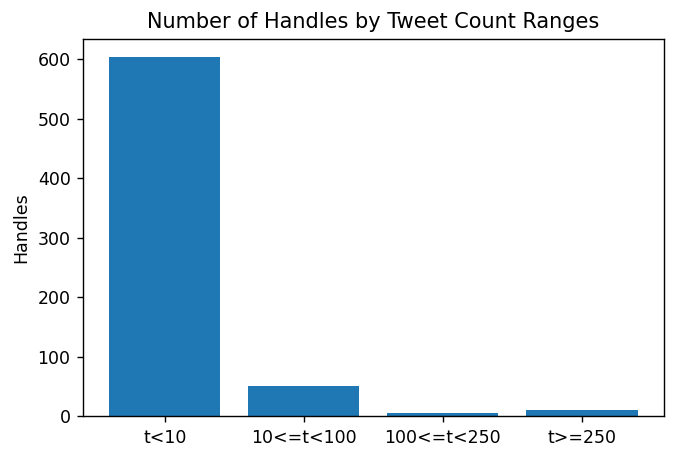

In [9]:
plt.rcParams['figure.dpi'] = 125
fig, ax = plt.subplots() 
ax.set_title('Number of Handles by Tweet Count Ranges')
ax.set_ylabel('Handles')
ax.bar(labels,counts)
plt.show()

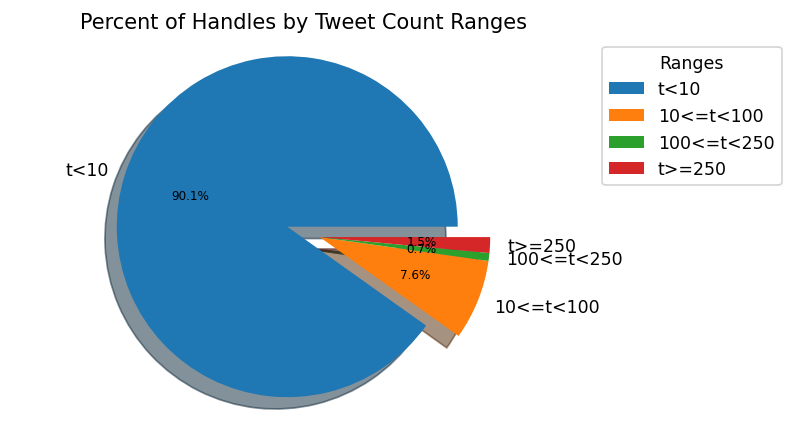

In [10]:
plt.rcParams['figure.dpi'] = 125
explode = (0.1,0,0,0)
_, ax1 = plt.subplots()
wedges, _, autotexts = ax1.pie(counts,labels=labels, explode=explode, shadow=True, autopct='%1.1f%%', radius=0.5)
ax1.legend(wedges, labels,
          title="Ranges",
          loc="upper left",
          bbox_to_anchor=(1, 0, 0, 1))
ax1.axis('equal')
ax1.set_title("Percent of Handles by Tweet Count Ranges")
plt.setp(autotexts, size='x-small')
plt.show()

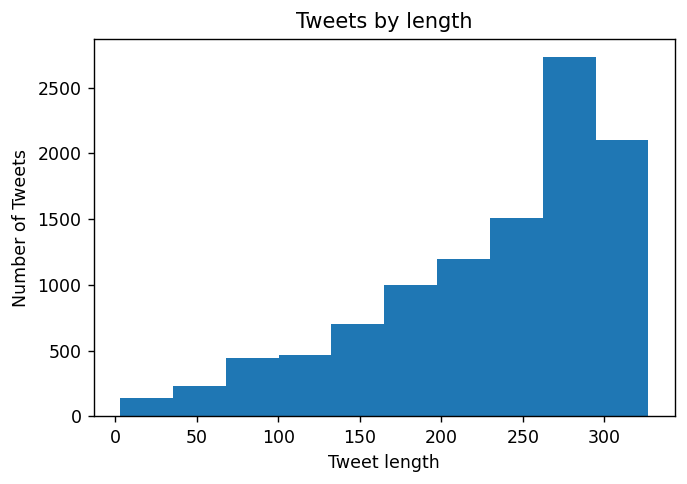

In [11]:
tweet_lengths = archive_data.text.astype("string").map(len)
_, ax1 = plt.subplots()
ax1.hist(tweet_lengths)
ax1.set_title("Tweets by length")
ax1.set_ylabel("Number of Tweets")
ax1.set_xlabel("Tweet length")
plt.show()


### Here is a graph showing the average of the compound sentiment scores, across all tweets, for each month.
The compound sentiment score is normalized to be between -1 <= *s* < 1, with *-1 as extremely negative*, and *1 as extremely positive*.  

Generally, 
- Positive sentiment is > 0.5 
- Neutral is between -0.5 and 0.5 
- Negative is < -0.5.

Interestingly, it looks as if there is a trend upwards in sentiment each time the daily case count begins to rise. The most negative sentiment also seems to happen around the time when the case count has returned to its approximate previous lows, similar to Jun-Aug 2020. 

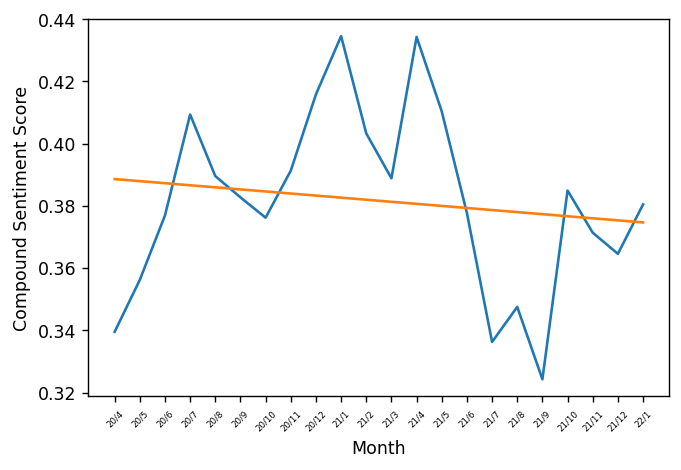

In [12]:
#Create a new series which is the average of the sentiment scores 
#over a month period across all tweets
date_index = pd.DatetimeIndex(pd.to_datetime(archive_data.crawl_date))
s = pd.Series(archive_data.v_comp.to_list(), index=date_index)
msa = s.resample('1M').mean() #month sample average


#assign data to axis
x_tick_labels = list(map(lambda d: "{}/{}".format(d.year%100,d.month),msa.index))
x = range(len(msa.index))
y = msa.to_numpy()

_, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=5)
plt.xticks(x, x_tick_labels, rotation=45)
ax.plot(x, y)
ax.set_xlabel("Month")
ax.set_ylabel("Compound Sentiment Score")
plt.rcParams['figure.dpi'] = 150

#compute trend line
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x))
plt.show()

![Covid Daily Cases](https://toronto.citynews.ca/wp-content/blogs.dir/sites/10/2021/12/15/CTCN-WED-DEC-15-ONT-COVID-CASES-GFX-GRAPH-2021DEC15-640x360.jpg)

### Select handles that have > 10 tweets and find the most positive and negative handles

In [13]:
gt10 = archive_data.groupby('handle').text.count() > 10
gt10 = gt10[gt10] #confusing statement, but all this does is remove rows that are not False
pruned = archive_data[archive_data.handle.isin(gt10.keys())]

#Calculate average of compound sentiment for each handle
avg_vcomp = pruned.groupby('handle')['v_comp'].mean()
print("The most negative handle is: ", avg_vcomp.idxmin(),avg_vcomp.min())
print("The most positive handle is: ", avg_vcomp.idxmax(),avg_vcomp.max())


The most negative handle is:  @511ONCentral -0.250175
The most positive handle is:  @OUAsport 0.6854428571428571


### So what exactly does VADAR consider negative/positive? Let's take a look.

In [14]:
negative_tweets = pruned[pruned.handle == avg_vcomp.idxmin()]
for text in negative_tweets.text[:5]:
    print(text)
    print()


#Roadwork #StCatharines #Thorold #HWY58 NB and SB from Thorold Stone Road/Davis Road to Pine Street will be fully closed from midnight May 4 until 6 am May 18, 2020 - Use alternate route. 

Update: #Closure #StCatharines #QEW both directions Off-ramps at #HWY406 SB are fully closed due to a Police Investigation. #ONHwys 

#Roadwork #StCatharines On-ramp to #HWY406 NB from Glendale Ave closed daily from 6am to 6pm on June 1 to 5, 2020. Access will remain open for emergency vehicles 

#Roadwork #Thorold #HWY58 NB off-ramp to HWY406 NB - Off-ramp lanes will be closed from 9am until 4pm on June 10 and 11, 2020. 

#Roadwork #StCatharines On-ramp to #HWY406 SB from #HWY58 NB will be fully closed from 6am to 2pm on Nov 7, 2020. No access to #HWY406 SB from #HWY58 NB. 



### Well, nobody likes traffic...

In [15]:
positive_tweets = pruned[pruned.handle == avg_vcomp.idxmax()]
for text in positive_tweets.text[:5]:
    print(text)
    print()

🏆 | They came, they played, they conquered. After seasons of unmatched skill and triumph, these all-star talents have their sights set on adding a top conference honour to their trophy case. The 2019-20 #OUA Male Athlete of the Year nominees are... #WeAreONE | #HonourAwards… https://t.co/FbsbGIGqYY 

🏆 | They’ve compiled sensational seasons to lead their respective squads, and now, they will look to cap off their accolade-filled campaigns with the conference’s top individual honour. The 2019-20 #OUA Female Athlete of the Year nominees are... #WeAreONE | #HonourAwards… https://t.co/D5W8LOvTfl 

🏆 | Congratulations goes to play-by-play commentator Matt Bonomi from the @brockbadgers for being named the Best #OUA Webcast Announcer for the 2019-20 season! 🎙️ #WeAreONE | #WeAreBadgers | #CHAMPAwards… https://t.co/slraDBQdXc 

#BannerSeason | ⏪🤼‍♂️ We use the same formula every year - teamwork, careful scouting, great coaching, and a stellar lineup. [Winning] with this formula means the conti

### Well that looks pretty positive! Unfortunately neither of the handle's tweets have to do with Covid... but what if we looked for sentiment in tweets explicitly mentioning Covid?

In [16]:
#This time examine handles with > 10 tweets explicitly mentioning covid
covid_tweet_map = archive_data.text.str.contains('covid',case=False)
covid_tweets = archive_data[covid_tweet_map]


gt10 = covid_tweets.groupby('handle').text.count() > 10
gt10 = gt10[gt10] #confusing statement, but all this does is remove rows that are not False
covid_tweets = covid_tweets[covid_tweets.handle.isin(gt10.keys())]
print("Examining tweets from handles with > 10 tweets mentioning Covid. Result: {}".format(len(covid_tweets)))

#Calculate average of compound sentiment for each handle
avg_vcomp = covid_tweets.groupby('handle')['v_comp'].mean()

print()
print("The most negative handle is: ", avg_vcomp.idxmin(),avg_vcomp.min())
print("-------------------------------------------------------")
negative_tweets = covid_tweets[covid_tweets.handle == avg_vcomp.idxmin()]
for text in negative_tweets.text[:5]:
    print(text)
    print()

print("The most positive handle is: ", avg_vcomp.idxmax(),avg_vcomp.max())
print("-------------------------------------------------------")
positive_tweets = covid_tweets[covid_tweets.handle == avg_vcomp.idxmax()]
for text in positive_tweets.text[:5]:
    print(text)
    print()


Examining tweets from handles with > 10 tweets mentioning Covid. Result: 1095

The most negative handle is:  @ONThealth 0.1591735294117647
-------------------------------------------------------
More regions will move into Stage 2 on Friday, June 19:  •@DurhamHealth •@HNHealthUnit •@RegionofHalton •@cityofhamilton •@lambton_ph •@NiagaraRegion •@YorkRegionGovt These regions join the 24 public health regions that opened on June 12. #COVID19ON https://t.co/mekuqqUx9T… https://t.co/H6lPHnqLkD 

As part of the #COVID19 fall preparedness plan, Ontario is expanding access to COVID-19 testing to pharmacies starting Sept 25. This will prepare the health system & support frontline care providers’ readiness for a second wave of COVID-19. https://t.co/tySrym9ad8… https://t.co/x7WeuuzpPB 

Ontario is ordering a Provincewide Shutdown requiring Ontarians to stay at home as much as possible to stop the spread of #COVID19. These measures will protect health system capacity and save lives by breaking th

### Download Data

Original data with duplicate tweets removed

In [17]:
#archive_data has at this point already had duplicates removed in an earlier cell
archive_data.to_csv('original_tweets_no_duplicates.csv',index=False)
files.download('original_tweets_no_duplicates.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tweets explicitly containing the word 'Covid'

In [18]:
covid_tweet_map = archive_data.text.str.contains('covid',case=False)
archive_data[covid_tweet_map].to_csv('covid_explicit_tweets.csv', index=False)
files.download('covid_explicit_tweets.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tweets containing the word 'Covid', but only from accounts containing at least 10 such instances.

In [19]:
covid_tweets.to_csv('covid_tweets_gt10.csv', index=False)
files.download('covid_tweets_gt10.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>